<a href="https://colab.research.google.com/github/GolfSuradej/IrisPAD/blob/main/IrisSegment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install opencv-python numpy

In [ ]:
import numpy as np
import cv2
from google.colab import files
from IPython.display import Image
from skimage import io
from google.colab.patches import cv2_imshow

In [ ]:
uploaded = files.upload()

Saving 8MP example crop 1 eye.jpg to 8MP example crop 1 eye.jpg


In [37]:
for k, v in uploaded.items():
  open(k, "wb").write(v)
#image = io.imread("/content/8MP example crop 1 eye.jpg",)
image = cv2.imread(k, cv2.IMREAD_GRAYSCALE)
# cv2_imshow(image)

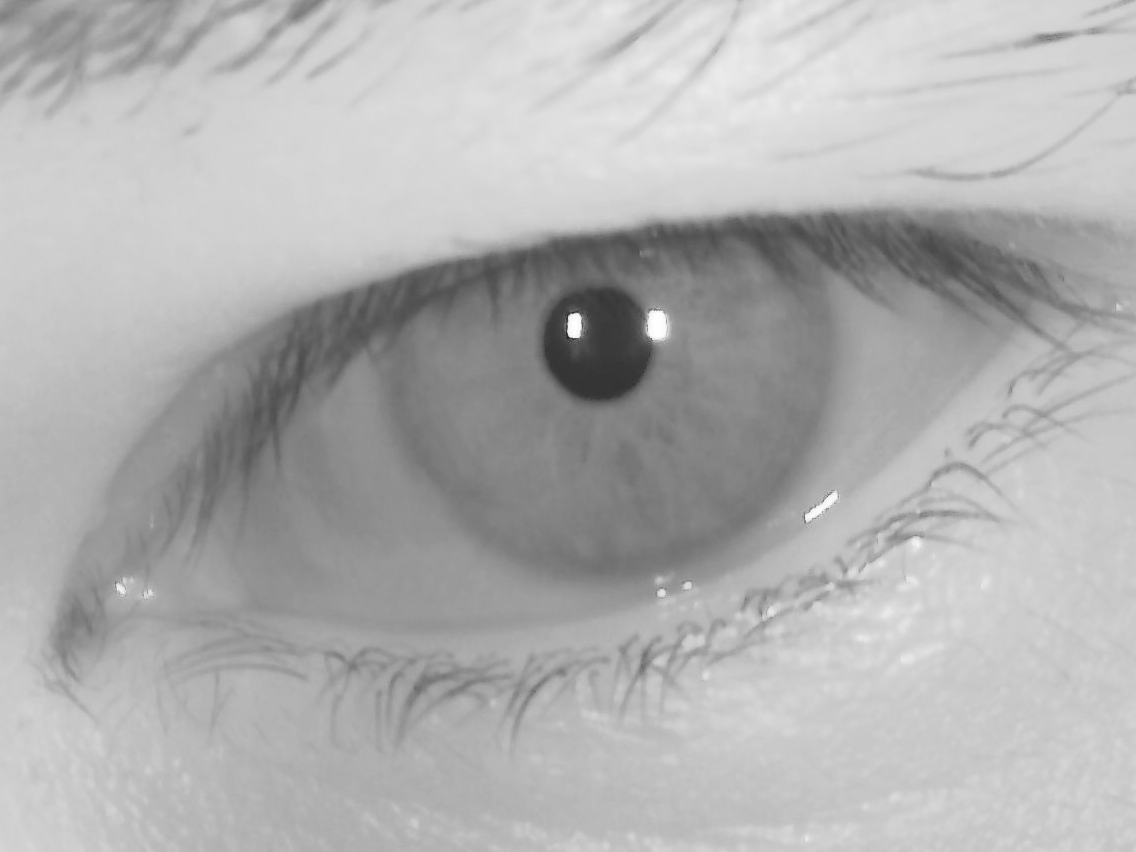

In [38]:
cv2_imshow(image)

In [41]:
def local_minima(image):
    height, width = image.shape

    r, c = 1, 1

    board = np.zeros((height, width), np.uint8)
    while r + 1 < height:
        c = 1
        while c + 1 < width:
            value = image[r, c]
            minimum = np.amin(image[r-1:r+1, c-1:c+1])
            if minimum != value:
                board[r, c] = 255
            c = c + 1
        r = r + 1

    result = image | board
    return result


def preprocessing(image):
    height, width = image.shape
    resize_image = cv2.resize(image, (width // 3 * 2, height // 3 * 2), cv2.INTER_CUBIC)
    kernel = np.ones((3,3), np.uint8)
    eroded = cv2.erode(resize_image, kernel)
    return eroded


def find_target_pixel(preprocess_image, max_r):
    crop_image = preprocess_image[max_r:-max_r, max_r:-max_r]

    _, binary_image = cv2.threshold(crop_image, 127.5, 255, cv2.INTER_CUBIC)

    crop_N_binary = crop_image | binary_image

    minima_image = local_minima(crop_N_binary)
    return minima_image


def conv_2d(image, x, y, mask):
    height, width = mask.shape
    masking_image = image[y-height//2: y+height//2, x-width//2: x+width//2] & mask
    count = np.count_nonzero(mask)

    return np.sum(masking_image)/count


def Daughman_Algorithm(image, preprocess, r_max=150):
    r_min = 15
    height, width = image.shape
    max_value, max_x, max_y, max_r = 0, 0, 0, 0
    daughman_values = np.zeros((height-r_max*2,width-r_max*2, r_max - r_min + 1), np.float)

    # Calculate the gradient using Sobel operator
    sobel_x = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=3)
    sobel_y = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=3)
    gradient_magnitude = np.hypot(sobel_x, sobel_y)

    # Compute unit gradient vectors
    unit_gradient_x = np.divide(sobel_x, gradient_magnitude, out=np.zeros_like(sobel_x), where=gradient_magnitude!=0)
    unit_gradient_y = np.divide(sobel_y, gradient_magnitude, out=np.zeros_like(sobel_y), where=gradient_magnitude!=0)

    for r in range(r_min, r_max+1):
        print("process..... ", r)
        mask = np.zeros((r*2,r*2), np.uint8)
        mask = cv2.circle(mask,(r, r), r, (255), thickness=1)

        for y in range(r_max, height - r_max):
            for x in range(r_max, width - r_max):
                pre_loc_x = x-r_max
                pre_loc_y = y-r_max
                if preprocess[pre_loc_y, pre_loc_x] != 255:
                    daughman_values[pre_loc_y, pre_loc_x, r - r_min] = conv_2d(image, x, y, mask) + \
                                                                       gradient_magnitude[y, x] + \
                                                                       unit_gradient_x[y, x] + \
                                                                       unit_gradient_y[y, x]


    diff_list = []
    for r in range(r_min, r_max-1):
        for y in range(r_max, height - r_max):
            for x in range(r_max, width - r_max):
                pre_loc_x = x-r_max
                pre_loc_y = y-r_max
                diff = daughman_values[pre_loc_y, pre_loc_x, r - r_min] - daughman_values[pre_loc_y, pre_loc_x, r - r_min + 1]
                if abs(diff) > max_value:
                    diff_list.append(abs(diff))
                    max_value = abs(diff)
                    max_x = x
                    max_y = y
                    max_r = r

    circle = cv2.circle(image, (max_x, max_y), max_r, 255, 1)
    max_value = 0
    pupil = (max_x, max_y, max_r)
    for r in range(max_r+10, r_max):
        diff = daughman_values[pre_loc_y, pre_loc_x, r - r_min] - daughman_values[max_y - r_max, max_x - r_max, r -r_min+1]
        if max_value < abs(diff):
            max_value = abs(diff)
            max_r = r

    circle_image = cv2.circle(circle, (max_x, max_y), max_r, 255, 1)
    iris = (max_x, max_y, max_r)
    return pupil, iris, circle_image


<ipython-input-41-de30817c53a9>:52: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  daughman_values = np.zeros((height-r_max*2,width-r_max*2, r_max - r_min + 1), np.float)


process.....  15
process.....  16
process.....  17
process.....  18
process.....  19
process.....  20
process.....  21
process.....  22
process.....  23
process.....  24
process.....  25
process.....  26
process.....  27
process.....  28
process.....  29
process.....  30
process.....  31
process.....  32
process.....  33
process.....  34
process.....  35
process.....  36
process.....  37
process.....  38
process.....  39
process.....  40
process.....  41
process.....  42
process.....  43
process.....  44
process.....  45
process.....  46
process.....  47
process.....  48
process.....  49
process.....  50
process.....  51
process.....  52
process.....  53
process.....  54
process.....  55
process.....  56
process.....  57
process.....  58
process.....  59
process.....  60
process.....  61
process.....  62
process.....  63
process.....  64
process.....  65
process.....  66
process.....  67
process.....  68
process.....  69
process.....  70
process.....  71
process.....  72
process.....  

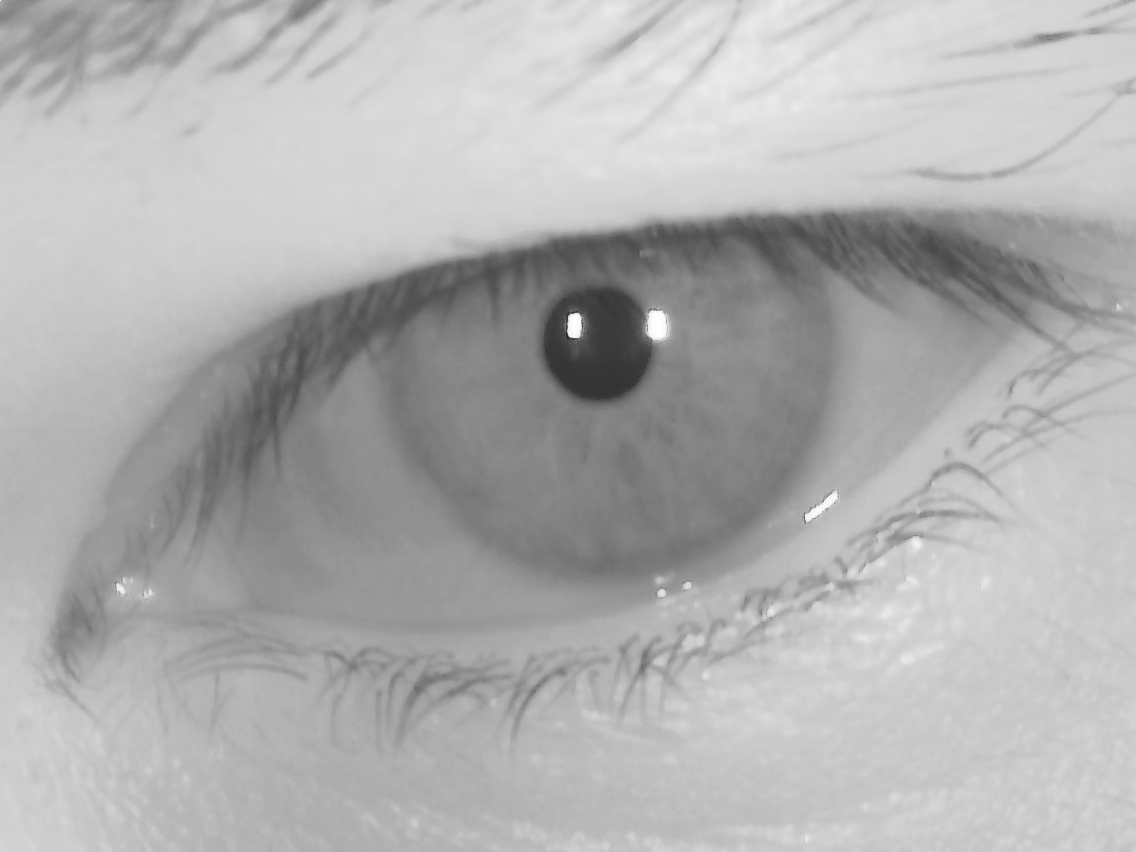

In [42]:
pp, ir, cir = Daughman_Algorithm(image, None, 150)
cv2_imshow(image)

In [ ]:
# from daugman import find_iris

In [ ]:
# gray_img = cv2.cvtColor(cv2.imread(k), cv2.COLOR_BGR2GRAY)
# answer = find_iris(gray_img, daugman_start=10, daugman_end=300, daugman_step=1, points_step=3)

Your image is not a square!


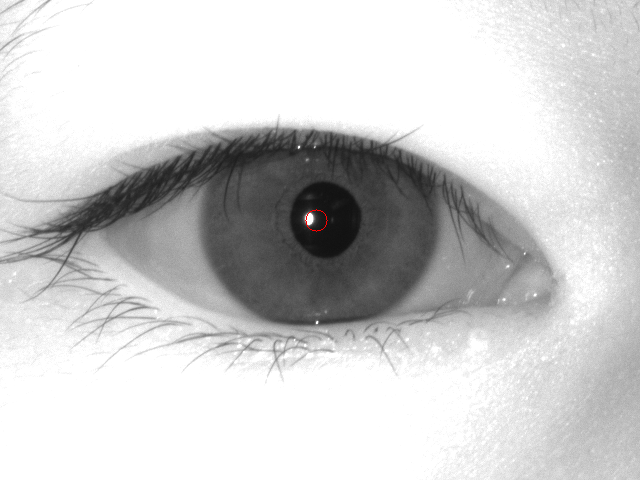

In [ ]:
# out = cv2.imread(k)
# iris_center, iris_rad = answer
# cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)
# cv2_imshow(out)